In [ ]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

Segmentation Models: using `tf.keras` framework.


In [ ]:
BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256


In [ ]:
num_images_to_read = 1500
counter = 0
#Capture training image info as a list
train_images = []
for directory_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/train_patches"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.tif"))):

      if counter>=num_images_to_read:
        break
      #print(img_path)
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      #img = cv2.resize(img, (SIZE_Y, SIZE_X))
      #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      train_images.append(img)
      counter += 1
      #train_labels.append(label)
#Convert list to array for machine learning processing
train_images = np.array(train_images)
train_images.shape

(1024, 256, 256, 3)

In [ ]:
num_images_to_read = 1500
counter = 0
#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/mask_patches"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.tif"))):
      if counter >=num_images_to_read:
        break
      mask = cv2.imread(mask_path, 0)

      #mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
      #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
      train_masks.append(mask)
      counter +=1
      #train_labels.append(label)
#Convert list to array for machine learning processing
train_masks = np.array(train_masks)
train_masks.shape
print(np.unique(train_masks))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [ ]:
train_masks[train_masks>0]=255
train_masks=train_masks/255.
train_masks=train_masks.astype(int)
print(np.unique(train_masks))

[0 1]


In [ ]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3) #expand dimension for compatibility with X
print(X.shape); print(Y.shape)

(1024, 256, 256, 3)
(1024, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [ ]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse', sm.metrics.iou_score, sm.metrics.f1_score])

258434480/258434480 [==============================] - 6s 0us/step


In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 64)       1728      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 64)       256       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, None, None, 64)       0         ['stem_bn[0][0]']         

In [ ]:
history=model.fit(x_train,
          y_train,
          batch_size=8,
          epochs=50,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/50
103/103 [==============================] - 236s 772ms/step - loss: 0.1542 - mse: 0.0424 - iou_score: 0.5488 - f1-score: 0.6974 - val_loss: 8.2473 - val_mse: 0.4309 - val_iou_score: 0.2407 - val_f1-score: 0.3872
Epoch 2/50
103/103 [==============================] - 71s 691ms/step - loss: 0.0965 - mse: 0.0274 - iou_score: 0.6875 - f1-score: 0.8137 - val_loss: 0.1274 - val_mse: 0.0364 - val_iou_score: 0.6485 - val_f1-score: 0.7859
Epoch 3/50
103/103 [==============================] - 71s 689ms/step - loss: 0.0880 - mse: 0.0253 - iou_score: 0.7094 - f1-score: 0.8291 - val_loss: 0.1291 - val_mse: 0.0361 - val_iou_score: 0.6713 - val_f1-score: 0.8016
Epoch 4/50
103/103 [==============================] - 72s 699ms/step - loss: 0.0781 - mse: 0.0224 - iou_score: 0.7401 - f1-score: 0.8502 - val_loss: 0.1082 - val_mse: 0.0291 - val_iou_score: 0.7194 - val_f1-score: 0.8358
Epoch 5/50
103/103 [==============================] - 72s 701ms/step - loss: 0.0719 - mse: 0.0207 - iou_score: 0.75

In [ ]:
accuracy = model.evaluate(x_val, y_val)
print(accuracy)

7/7 [==============================] - 12s 1s/step - loss: 0.1290 - mse: 0.0256 - iou_score: 0.7902 - f1-score: 0.8827
[0.12895701825618744, 0.025590280070900917, 0.7901568412780762, 0.8827294111251831]


In [ ]:
iou_train = history.history['iou_score']
iou_val = history.history['val_iou_score']

f1_train = history.history['f1-score']
f1_val = history.history['val_f1-score']

mse_train = history.history['mse']
mse_val = history.history['val_mse']

loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1, len(iou_train) + 1)

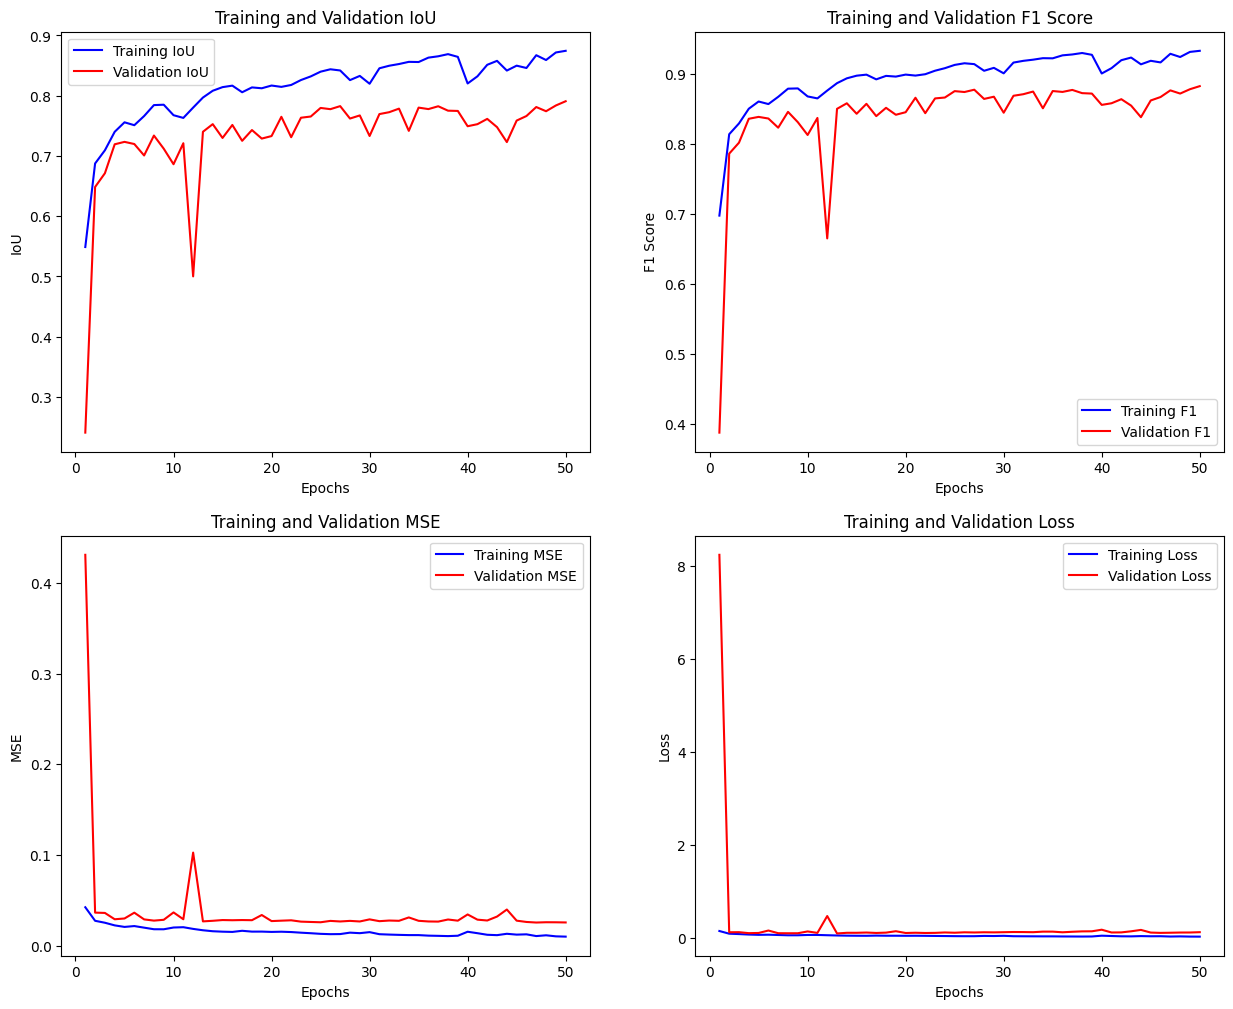

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

# Plotting IoU
plt.subplot(2, 2, 1)
plt.plot(epochs, iou_train, 'b', label='Training IoU')
plt.plot(epochs, iou_val, 'r', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Plotting F1 Score
plt.subplot(2, 2, 2)
plt.plot(epochs, f1_train, 'b', label='Training F1')
plt.plot(epochs, f1_val, 'r', label='Validation F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Plotting MSE
plt.subplot(2, 2, 3)
plt.plot(epochs, mse_train, 'b', label='Training MSE')
plt.plot(epochs, mse_val, 'r', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plotting Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, loss_train, 'b', label='Training Loss')
plt.plot(epochs, loss_val, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#plt.tight_layout()
# Save the figure
output_path = '/content/drive/MyDrive/Colab Notebooks/Unet-transferlearning/256_model_graphs/256Unet_TLearning_1024efficeientnetb7_50epochs_complete.png'
plt.savefig(output_path)
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Unet-transferlearning/256unet_Tlearnefficientnetb7_50epoch_1024img.h5')

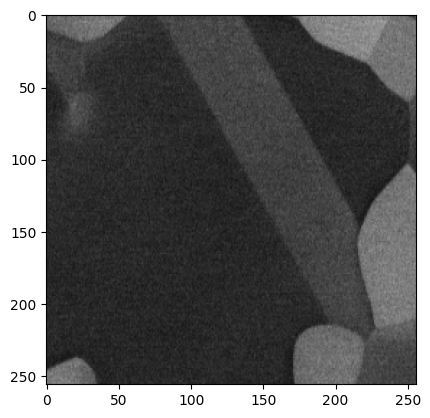

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Unet-transferlearning/256unet_Tlearnefficientnetb7_50epoch_1024img.h5', compile=False)
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_10.tif', cv2.IMREAD_COLOR)
plt.imshow(test_img)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img=preprocess_input(test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

In [ ]:
prediction = model.predict(test_img)

1/1 [==============================] - 6s 6s/step


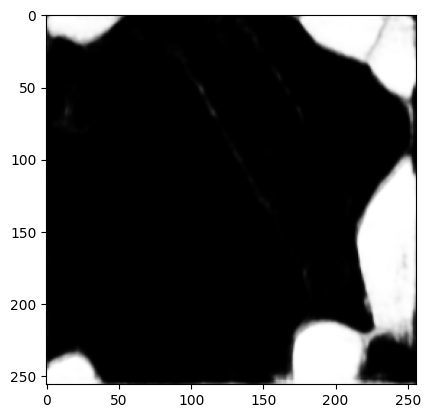

In [ ]:
#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
#plt.imsave('membrane/test0_segmented.jpg', prediction_image, cmap='gray')

In [ ]:
########test on differebt image######

In [ ]:
import glob
import cv2

# Assuming images are stored in the "images" directory and have .tif extension
image_directory = "/content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches"
image_files = glob.glob(f"{image_directory}/*.tif")

# Enumerate and process the image files
test_patches1=[]
for index, file_path in enumerate(image_files):
    # Read the image
    image = cv2.imread(file_path,cv2.IMREAD_COLOR)
    image=np.array(image)
    #image=np.expand_dims(image , axis=2)
    test_patches1.append(image)


    # Process the image
    # ...

    # Print the index and file path
    print(f"Image {index + 1}: {file_path}")
print(len(test_patches1))
test_patches1=np.array(test_patches1)
test_patches1.shape
#test_patches1=test_patches1/255.

Image 1: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_0.tif
Image 2: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_1.tif
Image 3: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_2.tif
Image 4: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_3.tif
Image 5: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_4.tif
Image 6: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_5.tif
Image 7: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_6.tif
Image 8: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_7.tif
Image 9: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_8.tif
Image 10: /content/drive/MyDrive/Colab Notebooks/unet/patches/patches_256/test_patches/patch_9.tif
Image 11: /content/

(64, 256, 256, 3)

In [ ]:
test_patches1=preprocess_input(test_patches1)

In [ ]:
IMG_HEIGHT = test_patches1.shape[1]
IMG_WIDTH  = test_patches1.shape[2]
IMG_CHANNELS = test_patches1.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)


(256, 256, 3)


In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/Colab Notebooks/Unet-transferlearning/256unet_Tlearnefficientnetb7_50epoch_768img.h5')
prediction1=model.predict(test_patches1)
prediction_thresholded1=(prediction1>0.5).astype(np.uint8)
prediction_thresholded1.shape

2/2 [==============================] - 5s 506ms/step


(64, 256, 256, 1)

In [ ]:
reshaped_array1 = np.reshape(prediction_thresholded1, (8, 8, 256, 256, 1))
reshaped_array1 = np.squeeze(reshaped_array1)
reshaped_array1.shape

(8, 8, 256, 256)

In [ ]:
!pip install patchify
from patchify import patchify, unpatchify

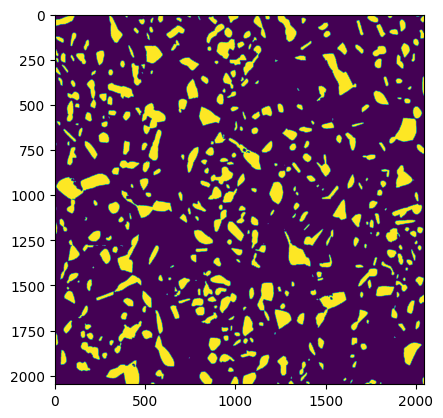

In [ ]:
reconst_image1=unpatchify(reshaped_array1,(2048,2048))
plt.imshow(reconst_image1)
plt.imsave('/content/drive/MyDrive/Colab Notebooks/Unet-transferlearning/0900c_500h_area1_tlefficientnetb7_epoch50.jpg', reconst_image1, cmap='gray')

In [ ]:
###########Random images####